In [1]:
%matplotlib inline 
import numpy as np 
import matplotlib.pylab as plt 
import pandas as pd 
import seaborn as sns 
sns.set_style('ticks');
current_colors = sns.color_palette()
from scipy.optimize import minimize
from scipy.optimize import brentq

In [2]:
def find_mut_pos(mutation):
    mut_list = mutation.split(':')
    return np.array(map(lambda x: 20-int(x[:-1]), mut_list))

def exctract_2MM_data(Boyle_data, col_name):
    data = Boyle_data.copy()
    data= data[data['seq'].apply(lambda x: x[-2:]=='GG')]
    data.drop(['p5', 'p95', 'seq', 'series', 'count'], axis=1, inplace=True)
    data['se2'] = data['se']**2
    data = data[data['nmut']==2]
    data['MM_pos'] = data['mutations'].apply(find_mut_pos)
    data['MM_pos'] = data['MM_pos'].apply(lambda x: list(x[x>0]))
    data.drop(['nmut'], axis=1, inplace=True)
    data = data[data['MM_pos'].apply(len)>0]
    data = data[data['MM_pos'].apply(len)==2]
    data['1st_MM_pos'] = data['MM_pos'].apply(lambda x: x[1])
    data_2MM_av = data[['1st_MM_pos', col_name]].groupby('1st_MM_pos').mean()
    data_2MM_av['se'] = ((data[['1st_MM_pos', 'se2']].groupby('1st_MM_pos').sum())/(data[['1st_MM_pos', 'se2']].groupby('1st_MM_pos').count())).apply(np.sqrt)
    data_2MM_av.reset_index(inplace=True)
    return data_2MM_av

def calc_app_rate(k, ti=0.5, tf=1.5):
    k_app = (np.exp(-k*ti)-np.exp(-k*tf))/(tf-ti)
    return k_app

def two_state_model(koff,kon,ti=0.5, tf=1.5):
    k = kon+koff
    Pi = (kon/k)*(1-np.exp(-k*ti))
    Pf = (kon/k)*(1-np.exp(-k*tf))
    App_kon = (Pf-Pi)/(tf-ti)
    return App_kon

## Double-Mismatch on-rate

In [3]:
on_data = pd.read_csv('../Data_Boyle/second_fit_data.summarized.on.1nM.rep1.txt',delimiter='\t')
on_data['slope'] = 1000*on_data['slope']
on_data['se'] = 1000*on_data['se']
on_data.rename(columns={'slope': 'App_on_rate ($10^{-3}$Hz)'}, inplace=True)
on_data_2MM = exctract_2MM_data(on_data, 'App_on_rate ($10^{-3}$Hz)')

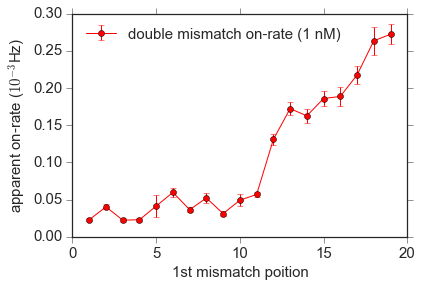

In [22]:
plt.figure(1)
plt.errorbar(on_data_2MM['1st_MM_pos'],
             on_data_2MM['App_on_rate ($10^{-3}$Hz)'], 
             yerr=on_data_2MM['se'], 
             marker='o', color='r', label = 'double mismatch on-rate (1 nM)')
plt.xlabel('1st mismatch poition', fontsize=15)
plt.ylabel('apparent on-rate ($10^{-3}$Hz)', fontsize=15)
plt.legend(fontsize=15, loc='best')
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

In [6]:
App_kon_WT = on_data[on_data['nmut']==0]['App_on_rate ($10^{-3}$Hz)'].iloc[0]
k_opt = minimize(lambda x: -1*calc_app_rate(x),x0=1).x[0]
kon_WT = brentq(lambda x: App_kon_WT-calc_app_rate(x),a=0, b=k_opt)

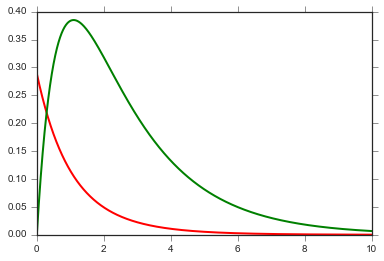

In [26]:
offrate_array = list(np.arange(0,10,0.001))
App_onrate_array = map(lambda x: two_state_model(koff=x,kon=kon_WT), offrate_array)
App_offrate_array = map(calc_app_rate, offrate_array)
plt.figure(2)
plt.plot(offrate_array, App_onrate_array, 'r', lw=2, label='apparent on-rate')
plt.plot(offrate_array, App_offrate_array, 'g', lw=2, label='apparent off-rate')

In [54]:
on_data_2MM

,1st_MM_pos,on_rate ($10^{-3}$Hz),se,Model_koff($10^{-3}$Hz)
0,1,0.022852,0.001835,0.282561
1,2,0.040321,0.003539,0.277861
2,3,0.022391,0.002265,0.282686
3,4,0.022878,0.002752,0.282554
4,5,0.041290,0.014577,0.277603
5,6,0.059720,0.005737,0.272742
6,7,0.036479,0.003801,0.278887
7,8,0.052154,0.007092,0.274726
8,9,0.031159,0.002909,0.280315
9,10,0.049225,0.007938,0.275498


In [43]:
calc_app_rate(kon_WT)

0.28884000000000354

In [42]:
App_kon_WT

0.28883999999999999

In [49]:
calc_app_rate(0.2)

0.16401919735424164

In [51]:
on_data_2MM

,1st_MM_pos,on_rate ($10^{-3}$Hz),se
0,1,0.022852,0.001835
1,2,0.040321,0.003539
2,3,0.022391,0.002265
3,4,0.022878,0.002752
4,5,0.041290,0.014577
5,6,0.059720,0.005737
6,7,0.036479,0.003801
7,8,0.052154,0.007092
8,9,0.031159,0.002909
9,10,0.049225,0.007938
